# 11 形态学操作

形态学操作包括: 膨胀 (dilation)、腐蚀 (erosion)、开操作 (opening)、闭操作 (closing).

以下形态学操作都是对于**二值化图像**而言的!!

## 腐蚀

对于**二值化图像**, 非黑即白. 假设背景是白色, 前景是黑色. 

若一个黑点上下左右4个点存在白色的, 则将该点也变成白的.

<br>

也可以类似定义其它的规则: 只要周围某几个像素中存在白色的, 则将该点也变成白色.  这就是腐蚀.


In [29]:
import numpy as np
def Erosion(img, pattern):
    """Erode an binary image with some pattern. Center of pattern should be 0 (black)."""
    N = pattern.shape[0] // 2
    img = img ^ 1
    img2 = np.pad(img, N, mode = 'constant', constant_values = 1)
    for i in range(pattern.shape[0]):
        for j in range(pattern.shape[1]):
            if pattern[i,j] == 0: # black
                # bitwise-and
                img &= img2[i:i+img.shape[0], j:j+img.shape[1]]
    img ^= 1
    return img

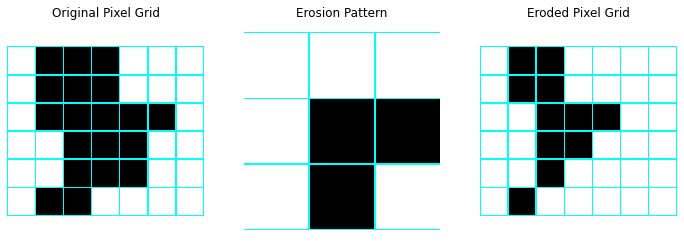

In [30]:
import numpy as np
from matplotlib import pyplot as plt

img = np.array([int(i) for i in bin(2458738291151)[2:]]).reshape((-1, 7))
pattern = np.array([[1,1,1],[1,0,0],[1,0,1]])
img_eroded = Erosion(img, pattern)

plt.figure(figsize = (12, 4))
for i, image, title in zip(range(1, 4), (img, pattern, img_eroded), \
        ('Original Pixel Grid', 'Erosion Pattern', 'Eroded Pixel Grid')):
    plt.subplot(1, 3, i)
    plt.pcolormesh(image[::-1,:], cmap = 'gray', edgecolors='aqua', linewidth=.5)
    plt.axis('equal')
    plt.axis('off')
    plt.title(title)
plt.show()

## 膨胀

腐蚀背景, 就是前景膨胀.

只要有一个点的周围有黑色, 就将其变为黑色.

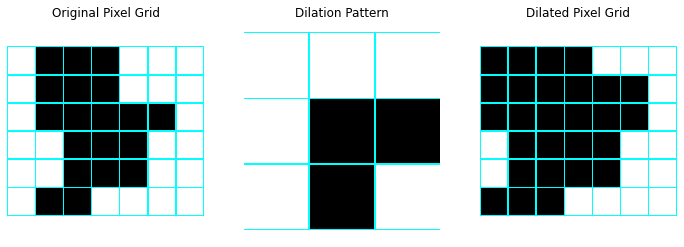

In [31]:
import numpy as np
from matplotlib import pyplot as plt

def Dilation(img, pattern):
    return Erosion(img ^ 1, pattern) ^ 1

img = np.array([int(i) for i in bin(2458738291151)[2:]]).reshape((-1, 7))
pattern = np.array([[1,1,1],[1,0,0],[1,0,1]])
img_eroded = Dilation(img, pattern)

plt.figure(figsize = (12, 4))
for i, image, title in zip(range(1, 4), (img, pattern, img_eroded), \
        ('Original Pixel Grid', 'Dilation Pattern', 'Dilated Pixel Grid')):
    plt.subplot(1, 3, i)
    plt.pcolormesh(image[::-1,:], cmap = 'gray', edgecolors='aqua', linewidth=.5)
    plt.axis('equal')
    plt.axis('off')
    plt.title(title)
plt.show()

## 开操作

先腐蚀再膨胀. 

这样大多数点会因为膨胀而恢复原样, 但如果是孤立的噪点就会被腐蚀掉.

## 闭操作

先膨胀再腐蚀. 

这样可以修补黑色中间的白色空隙.

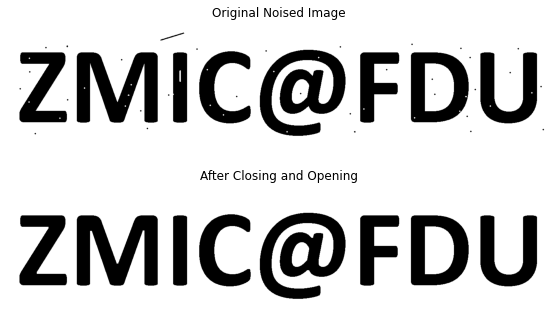

In [32]:
import os
from matplotlib import pyplot as plt
from PIL import Image 

def opening(img, pattern):
    return Dilation(Erosion(img, pattern), pattern)

def closing(img, pattern):
    return Erosion(Dilation(img, pattern), pattern)

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\zmic_fdu_noise.bmp')))
pattern = np.zeros((5, 5), dtype = 'bool')
img_processed = opening(closing(img, pattern), pattern)
plt.figure(figsize = (10, 5.5))
for i, image, title in zip(range(1, 3), (img, img_processed),\
        ('Original Noised Image', 'After Closing and Opening')):
    plt.subplot(2, 1, i)
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.title(title)
plt.show()

## 距离变换

距离变换 (distance transform) 计算二值化图像的前景每个像素到背景的距离. 可以用多源 BFS.

In [24]:
import numpy as np
from numba import jit
from numba.typed import List
@jit(nopython = True, cache = True)
def DistanceTransform(img):
    """Compute chessboard distance of each pixel. Background is zero."""
    img = img.copy().astype('int32')
    s = List()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == 0:
                s.append((i,j))
    img = np.where(img == 0, 0, -1)
    i = 0
    while i < len(s):
        x, y = s[i]
        for dx, dy in ((0,1),(0,-1),(-1,0),(1,0)):
            x2, y2 = x+dx, y + dy
            if 0 <= x2 < img.shape[0] and 0 <= y2 < img.shape[1] and img[x2, y2] == -1:
                img[x2, y2] = img[x, y] + 1
                s.append((x2, y2))
        i += 1
    return img


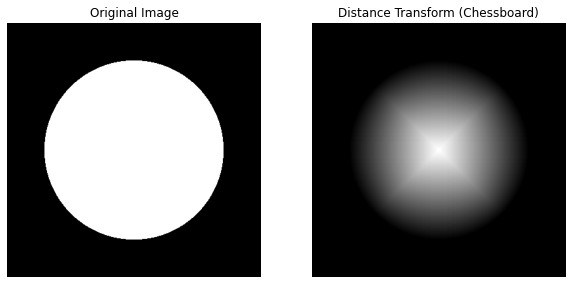

In [40]:
import os
from matplotlib import pyplot as plt
from PIL import Image 

N = 400
img = np.zeros((N, N))
coor = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
img = np.where(coor[0]**2 + coor[1]**2 < .5, 1, 0)
img_dist = DistanceTransform(img)
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_dist, cmap = 'gray')
plt.title('Distance Transform (Chessboard)')
plt.axis('off')
plt.show()